In [1]:
import numpy as np
from matplotlib import pyplot as plt
import glob

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

plt.style.use('seaborn')

nice_fonts = {
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 16,
        "font.size": 16,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 14,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
}

matplotlib.rcParams.update(nice_fonts)

In [3]:
def check_block_color(x,y):
    x[x==1]=0
    x[x==3]=2
    x[x==5]=4
    y[y==1]=0
    y[y==3]=2
    y[y==5]=4
    return np.sum(x==y)/x.shape[0]

In [16]:
# Load some data
gt_sink = []
obs_sink = []
gt_tcn = []
obs_tcn = []
gt_tcn_hung = []
obs_tcn_hung = []
for demos in range(10,1920,50):
    try:
        gt_sink.append(np.load('gt_actions_sink_%04d.npy'%demos,allow_pickle=True))
        obs_sink.append(np.load('actions_sink_%04d.npy'%demos,allow_pickle=True))
        
        gt_tcn_hung.append(np.load('gt_actions_tcn_hung_%04d.npy'%demos,allow_pickle=True))
        obs_tcn_hung.append(np.load('actions_tcn_hung_%04d.npy'%demos,allow_pickle=True))
        
        gt_tcn.append(np.load('gt_actions_tcn_%04d.npy'%demos,allow_pickle=True))
        obs_tcn.append(np.load('actions_tcn_%04d.npy'%demos,allow_pickle=True))
    except:
        continue;

In [17]:
def check_reps(obs_in):
    _,count = np.unique(obs_in,return_index=False,return_inverse=False,return_counts=True)
    return np.sum(count>1)

In [18]:
reps_sink = []
for obs in obs_sink:
    reps_sink.append(np.sum([check_reps(ob) for ob in obs])/obs.shape[0])

reps_tcn = []
for obs in obs_tcn:
    reps_tcn.append(np.sum([check_reps(ob) for ob in obs])/obs.shape[0])
    
reps_tcn_hung = []
for obs in obs_tcn_hung:
    reps_tcn_hung.append(np.sum([check_reps(ob) for ob in obs])/obs.shape[0])

In [19]:
demos = np.arange(10,1920,50,dtype='int')

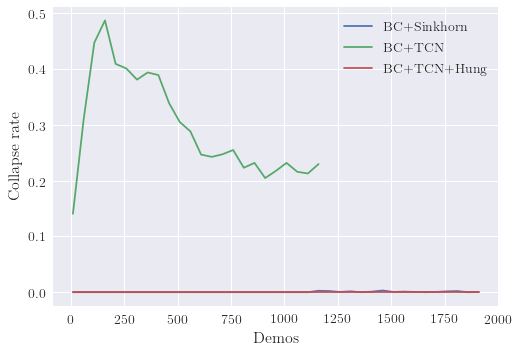

In [20]:
plt.plot(demos,reps_sink,label='BC+Sinkhorn')
plt.plot(demos[0:len(reps_tcn)],reps_tcn,label='BC+TCN')
plt.plot(demos[0:len(reps_tcn_hung)],reps_tcn_hung,label='BC+TCN+Hung')
plt.ylabel('Collapse rate')
plt.xlabel('Demos')
plt.legend()
plt.show()

In [21]:
pre_sink = []
for i in range(len(gt_sink)):
    pre_demo = []
    for j in range(len(gt_sink[0])):
        pre_demo.append(check_block_color(gt_sink[i][j],obs_sink[i][j]))
    pre_sink.append(pre_demo)
    

In [22]:
pre_tcn = []
for i in range(len(gt_tcn)):
    pre_demo = []
    for j in range(len(gt_tcn[0])):
        pre_demo.append(check_block_color(gt_tcn[i][j],obs_tcn[i][j]))
    pre_tcn.append(pre_demo)

In [23]:
pre_tcn_hung = []
for i in range(len(gt_tcn_hung)):
    pre_demo = []
    for j in range(len(gt_tcn_hung[0])):
        pre_demo.append(check_block_color(gt_tcn_hung[i][j],obs_tcn_hung[i][j]))
    pre_tcn_hung.append(pre_demo)

In [24]:
# Baseline (no generalisation)
from itertools import permutations 
obj_id_list = []
for r in range(2,7):
    obj_id_list = obj_id_list + list(permutations(range(0, 6),r=r))
    
perms = np.ones((len(obj_id_list),6))*100
seq_len = []
for j,obj_idx in enumerate(obj_id_list):
    seq_len.append(len(obj_idx))
    perms[j,0:len(obj_idx)] = obj_idx
    

In [25]:
baseline_pre = []
for d in demos:
    perms_copy = np.copy(perms)
    perms_shuffled = np.copy(perms_copy[d:,:])
    np.random.shuffle(perms_shuffled)
    perms_copy[d:,:] = perms_shuffled

    pre_list = []
    for k in range(perms.shape[0]):
        pre_list.append(np.sum(perms[k,:seq_len[k]]==perms_copy[k,:seq_len[k]])/seq_len[k])
    
    baseline_pre.append(pre_list)

In [26]:
hists_p_sink = []
for t in np.array(pre_sink):
    h,_ = np.histogram(t,np.linspace(0,1,10))
    hists_p_sink.append(h)

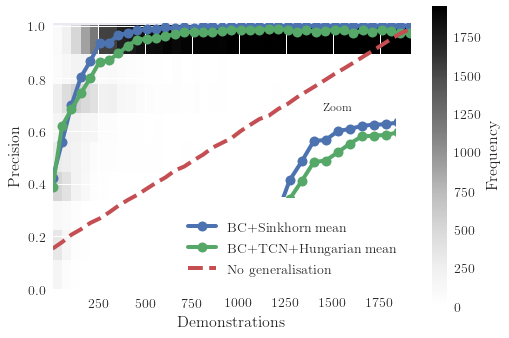

In [44]:
# Compare on precision distribution (nb precision is never perfect as there are multiple possible ways to build tower, better to compare order)
plt.imshow(np.vstack(hists_p_sink).T,extent=(demos[0],demos[-1],0,1.0),aspect=1400,origin='lower',interpolation='None')
plt.plot(demos[0:len(pre_sink)],[np.mean(pre) for pre in pre_sink],'-o',linewidth=4,label='BC+Sinkhorn mean',markersize=10)
plt.plot(demos[0:len(pre_tcn_hung)],[np.mean(pre) for pre in pre_tcn_hung],'-o',linewidth=4,label='BC+TCN+Hungarian mean',markersize=10)
#plt.plot(demos[0:len(pre_tcn)],[np.mean(pre) for pre in pre_tcn],'-o',linewidth=4,label='BC+TCN mean',markersize=10)
plt.plot(demos,[np.mean(pre) for pre in baseline_pre],'--',linewidth=4,label='No generalisation',markersize=10)

plt.colorbar(label='Frequency')
plt.legend(loc=('lower right'))
plt.ylabel('Precision')
plt.xlabel('Demonstrations')
plt.ylim(0,1.01)

ax2 = plt.axes([0.52, 0.4, .2, .2],facecolor='white',frameon=True)
plt.plot(demos[0:len(pre_sink)],[np.mean(pre) for pre in pre_sink],'-o',linewidth=4,label='BC+Sinkhorn',markersize=10)
plt.plot(demos[0:len(pre_tcn_hung)],[np.mean(pre) for pre in pre_tcn_hung],'-o',linewidth=4,label='BC+TCN+Hungarian',markersize=10)
#plt.plot(demos[0:len(pre_tcn)],[np.mean(pre) for pre in pre_tcn],'-o',linewidth=4,label='BC+TCN',markersize=10)
plt.plot(demos,[np.mean(pre) for pre in baseline_pre],'--',alpha=0.5,linewidth=4,label='No generalisation',markersize=10)
ax2.set_title('Zoom')
ax2.grid(True)
ax2.set_xlim([120,600])
ax2.set_ylim([0.75,1.01])
ax2.set_xticks([])
ax2.set_yticks([])

plt.savefig('Subset_generalisation.pdf')
plt.show()